# Machine Learning Dataset
This notebook will go through the steps of downloading MMS data for the machine learning project and creating a CSV file of the results. It will also be a small introduction to the structure of CDF files.

**Outline**
* [Setup: Creating the pymms Object](#pymms_object)
* [Working with CDF Files](#working_with_cdf_files)
  * [Downloading MMS CDF Files](#cdf_download)
  * [CDF Attributes and Variables](#cdf_attrs_vars)
* [Fluxgate Magnetometer (FGM)](#fgm)
  * [Down and Read](#fgm_download_read)
  * [Plot Data](#fgm_plot)
  * [Dataframe](#fgm_dataframe)
* [Electric Field Double Probes (EDP)](#edp)
  * [Down and Read](#edp_download_read)
  * [Plot Data](#edp_plot)
  * [Dataframe](#edp_dataframe)
* [FPI: Dual Ion Spectrometer (DIS)](#dis)
  * [Down and Read](#dis_download_read)
  * [Plot Data](#dis_plot)
  * [Dataframe](#dis_dataframe)
* [FPI: Dual Electron Spectrometer (DES)](#des)
  * [Down and Read](#des_download_read)
  * [Plot Data](#des_plot)
  * [Dataframe](#des_dataframe)
* [Electron Drift Instrument (EDI)](#edi)
  * [Down and Read](#edi_download_read)
  * [Plot Data](#edi_plot)
  * [Dataframe](#edi_dataframe)
* [Interpolate to DES](#interpolate_to_des)
* [Write to CSV](#write_to_csv)
* [SITL Selections](#sitl_selections)

<a id='pymms_object'></a>
## Creating the pymms object
First, we create an instance of the object that communicates with the SDC. For the sake of this example, we will start with data from `2015-10-16` because there are several magnetopause crossings and a well-studied electron diffusion region event. Also, for simplicity we will work with data from the MMS1 spacecraft. Data from other spacecraft can be loaded by changing the `sc` property below to `'mms2'`, `'mms3'`, or `'mms4'`.

In [1]:
import numpy as np
import datetime as dt
import spacepy
from spacepy import pycdf
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pymms
from pymms import mms_utils

# Create an instance of SDC object
sdc = pymms.MrMMS_SDC_API()

# Define the spacecraft. We will use the variable later when accessing the CDF files.
sc = 'mms1'
level = 'sitl'                    # 'l2' or 'sitl'
start_date = '2015-12-06'
end_date = '2015-12-06T23:59:59'
data_root = '/Users/argall/data/mms/' # Specifying data_root="~/" does not expand the tilde yet
                                      # However, if data_root=None, then ~/data is the default

# Set attributes
sdc.sc = sc
sdc.start_date = start_date
sdc.end_date = end_date
sdc.data_root = data_root

<a id='working_with_cdf_files'></a>
## Working with CDF Files
CDF files are somewhat like netCDF or HDF5 files in that the contain data as well as metadata. Data is associated with variable names and variable metadata, or variable attributes. The file itself has metadata in the form of global attributes. For our purpose, we are interested in determining the variable names, what they mean, then selecting the subset of variables that are relevant to us. To do that, we will need to download an MMS CDF data file and make use of pycdf from the spacepy package.

<a id='cdf_download'></a>
### Downloading an MMS CDF File
Here, we will give a brief example of how to download a CDF file using the `pymms` package. We pick a file from the fluxgate magnetometer (FGM) team containing magnetic field data. For demonstration purposes, we select a science-quality data file (`level='l2'`) when the instrument was sampling in survey mode (`mode='srvy'`). [Since the Geocentric Solar Ecliptic](https://sscweb.gsfc.nasa.gov/users_guide/Appendix_C.html) (GSE) coordinate system is the standard for MMS data, we will extract non-scalar data in this system.

In [ ]:
# First, define variables, as they will be used in creating variable names
fgm_mode = 'srvy'
fgm_coords = 'gse'
fgm_instr = 'fgm'
fgm_level = 'l2'

# Set object properties and get data
sdc.instr = fgm_instr
sdc.mode = fgm_mode
sdc.level = fgm_level
files = sdc.Download()

print('FGM Files:')
print(*files, sep='\n')

<a id='cdf_attrs_vars'></a>
### CDF Attributes and Variables
In order to access data in a CDF file, it is necessary to know the names of the variables contained within. Often, it is also important to know additional information about the file contents or variable data. This metadata is contained in the global and variable attributes.

The most important variable attributes are `CATDESC`, which describes the variable, `FILLVAL`, which gives the value used for bad or missing data, and `DEPEND_[0-3]`, which list the dependent variables of a data variable. Typically, the dimensions of CDF variables are ordered as `[nRecs, nDep1, nDep2, nDep3]`, where `nRecs` is the total number of records, each record having dimensions `[nDep1, nDep2, nDep3]`. The value of `DEPEND_0` is typically `'Epoch'`, indicating that the CDF variable `'Epoch'` is a dependency. The `'Epoch'` variable contains a CDF Epoch time stamp at each of the `nRecs` number of records. Similarly `DEPEND_[1-3]` variables point to other variables in the CDF file that act as dependencies. If you want to plot a variable, you will need to also extract its `'DEPEND_0'` variables.

Variables and attributes are described in more detail in the [ISTP CDF Guidelines](https://spdf.gsfc.nasa.gov/sp_use_of_cdf.html). Below, we demonstrate how to obtain attribute and variable names and values.

In [ ]:
# Open the file and pr
cdf = pycdf.CDF(files[0])

# Show global attribute
print('Global Attributes:')
for gAttrName in cdf.attrs:
    print('\t' + gAttrName)

# Show variable names
print('\nVariable Names:')
for varName in cdf:
    print('\t' + varName)

# Select the magnetic field variable
vname = '_'.join((sc, fgm_instr, 'b', fgm_coords, fgm_mode, fgm_level))

# Show variable attributes for a particular variable
print('\nVariable Attributes for "' + vname + '":')
for vAttrName in cdf[vname].attrs:
    print('\t' + vAttrName)

# Important variable attributes:
print('\nValues of Important Variable Attributes:')
print('\t', 'CATDESC: ', cdf[vname].attrs['CATDESC'])
print('\t', 'FILLVAL: ', cdf[vname].attrs['FILLVAL'])
print('\t', 'DEPEND_0: ', cdf[vname].attrs['DEPEND_0'])

<a id='fgm'></a>
## FGM
The FGM dataset contains magnetic field data from the fluxgate magnetometer (FGM). [Since the Geocentric Solar Ecliptic](https://sscweb.gsfc.nasa.gov/users_guide/Appendix_C.html) (GSE) coordinate system is the standard for MMS data, we will extract non-scalar data in this system.

<a id='fgm_download_read'></a>
### Download & Read Data
Now we can read data and its corresponding time stamps for a CDF variable. We choose the `'mms1_fgm_b_gse_srvy_l2'` variable because, as shown above, its `CATDESC` attribute describes it as the magnetic field in GSE coordinates. In order to be completely general, I will build the variable names from the attributes we have already defined. Variable names have the convention of `sc_instr_param_coords_optdesc_mode_level`, where `param` describes the quantity and `coords` is the coordinate system whenever relevant. Other components are similar to the file name conventions.

In [7]:
# Update instrument-specific variables
fgm_mode = 'srvy'
if level == 'sitl':
    fgm_coords = 'dmpa'
    fgm_instr = 'dfg'
    fgm_level = 'ql'
else:
    fgm_coords = 'gse'
    fgm_instr = 'fgm'
    fgm_level = 'l2'

# Set object properties
sdc.instr = fgm_instr
sdc.mode = fgm_mode
sdc.level = fgm_level

# Download data
files = sdc.Download()
files = mms_utils.sort_files(files)[0]

# Read the magnetic field and its time stamps
if level == 'l2':
    b_vname = '_'.join((sc, fgm_instr, 'b', fgm_coords, fgm_mode, fgm_level))
else:
    b_vname = '_'.join((sc, fgm_instr, fgm_mode, fgm_coords))

fgm_t = []
fgm_b = []

print('FGM Files:')
for file in files:
    # Open the file
    cdf = pycdf.CDF(file)
    
    # Read the data
    #   - Convert numpy arrays to lists to make appending easier
    fgm_t += list(cdf[cdf[b_vname].attrs['DEPEND_0']][:])
    fgm_b += list(cdf[b_vname][:])
    
    # Close the file
    cdf.close()
    print('  ' + file)

# Convert back to numpy arrays
fgm_t = np.array(fgm_t)
fgm_b = np.array(fgm_b)

# Compute clock and normal angles
fgm_ca = np.rad2deg(np.arctan2(fgm_b[:,1], fgm_b[:,2]))
fgm_tbn = np.rad2deg(np.arctan2(fgm_b[:,0], fgm_b[:,2]))

FGM Files:
  /Users/argall/data/mms1/dfg/srvy/ql/2016/10/mms1_dfg_srvy_ql_20161022_v2.53.3.cdf


<a id='fgm_plot'></a>
### Plot Data

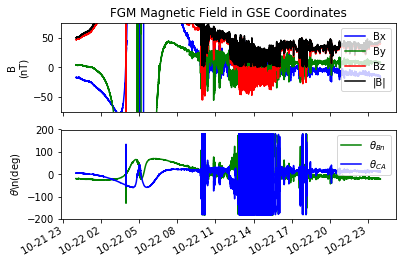

In [8]:
# Visualize the data
fig, ax = plt.subplots(nrows=2, ncols=1, squeeze=False)

fig.autofmt_xdate()

# B-field
hbx, = ax[0,0].plot(fgm_t, fgm_b[:,0], 'b', label='Bx')
hby, = ax[0,0].plot(fgm_t, fgm_b[:,1], 'g', label='By')
hbz, = ax[0,0].plot(fgm_t, fgm_b[:,2], 'r', label='Bz')
hb, = ax[0,0].plot(fgm_t, fgm_b[:,3], 'k', label='|B|')
ax[0,0].set_title('FGM Magnetic Field in GSE Coordinates')
ax[0,0].legend(loc='upper right')
ax[0,0].set_ylabel('B\n(nT)')
ax[0,0].set_ylim([-75,75])

# Angles
htbn, = ax[1,0].plot(fgm_t, fgm_tbn, 'g', label=r'$\theta_{Bn}$')
hca, = ax[1,0].plot(fgm_t, fgm_ca, 'b', label=r'$\theta_{CA}$')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel(r'$\theta$\n(deg)')

# Plot properties
#ax.set_xlabel('Time UTC (Month-Day Hour)')
#ax.fmt_xdata = mdates.DateFormatter('%m-%d %H:%M')
plt.show()

<a id='fgm_dataframe'></a>
### Data Frame

In [31]:
# Create a dictionary
fgm_data = {
    'Time' :  fgm_t,
    'Bx' : fgm_b[:,0],
    'By' : fgm_b[:,1],
    'Bz' : fgm_b[:,2],
    'Bmag' : fgm_b[:,3],
    'clock_angle' : fgm_ca,
    'normal_angle' : fgm_tbn
}

# Convert dictionary to data from
fgm_data = pd.DataFrame(fgm_data, columns=fgm_data.keys())

<a id='edp'></a>
## EDP
Now for electric field and spacecraft potential data from the Electric Field Double Pobles (EDP).

<a id='edp_download_read'></a>
### Download & Read

In [22]:
# Update instrument-specific variables
edp_instr = 'edp'
edp_mode = 'fast'
edp_level = level
dce_optdesc = 'dce'
scpot_optdesc = 'scpot'

if level == 'l2':
    edp_coords = 'gse'
else:
    edp_coords = 'dsl'

# EDP variable names
e_vname = '_'.join((sc, 'edp', dce_optdesc, edp_coords, edp_mode, edp_level))
scpot_vname = '_'.join((sc, 'edp', scpot_optdesc, edp_mode, edp_level))

# Download DCE files
sdc.instr = edp_instr
sdc.mode = edp_mode
sdc.level = edp_level
sdc.optdesc = dce_optdesc
dce_files = sdc.Download()
dce_files = mms_utils.sort_files(dce_files)[0]

# Download SCPOT files
sdc.optdesc = scpot_optdesc
scpot_files = sdc.Download()
scpot_files = mms_utils.sort_files(scpot_files)[0]

# Read the data
edp_t = []
edp_e = []
edp_v = []
print('EDP Files:')
for ifile, file in enumerate(dce_files):
    # Open the file
    dce_cdf = pycdf.CDF(dce_files[ifile])
    scpot_cdf = pycdf.CDF(scpot_files[ifile])
    
    # Read data and replace fill value with NaN
    e = dce_cdf[e_vname][:]
    v = scpot_cdf[scpot_vname][:]
    e[e == dce_cdf[e_vname].attrs['FILLVAL']] = np.nan
    v[v == scpot_cdf[scpot_vname].attrs['FILLVAL']] = np.nan
    
    # Read the data
    #   - Convert numpy arrays to lists to make appending easier
    edp_t += list(dce_cdf[dce_cdf[e_vname].attrs['DEPEND_0']][:])
    edp_e += list(e)
    edp_v += list(v)
    
    # Close the file
    dce_cdf.close()
    scpot_cdf.close()
    print('  ' + dce_files[ifile])
    print('  ' + scpot_files[ifile])

# Convert back to numpy arrays
edp_t = np.array(edp_t)
edp_e = np.array(edp_e)
edp_v = np.array(edp_v)

EDP Files:
  /Users/argall/data/mms1/edp/fast/sitl/dce/2016/10/mms1_edp_fast_sitl_dce_20161022_v0.1.3.cdf
  /Users/argall/data/mms1/edp/fast/sitl/scpot/2016/10/mms1_edp_fast_sitl_scpot_20161022_v0.1.3.cdf


<a id='edp_plot'></a>
### Plot

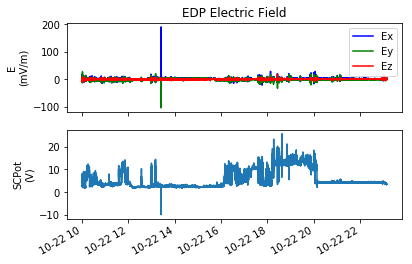

In [23]:
# Visualize the data
fig, ax = plt.subplots(nrows=2, ncols=1, squeeze=False)

fig.autofmt_xdate()

# E-field
hx, = ax[0,0].plot(edp_t, edp_e[:,0], 'b', label='Ex')
hy, = ax[0,0].plot(edp_t, edp_e[:,1], 'g', label='Ey')
hz, = ax[0,0].plot(edp_t, edp_e[:,2], 'r', label='Ez')
ax[0,0].set_title('EDP Electric Field')
ax[0,0].legend(loc='upper right')
ax[0,0].set_ylabel('E\n(mV/m)')

# Spacecraft Potential
hv, = ax[1,0].plot(edp_t, edp_v)
ax[1,0].set_ylabel('SCPot\n(V)')

plt.show()

<a id='edp_dataframe'></a>
### Data Frame

In [ ]:
# Create a dictionary
edp_data = {
    'Time' :  edp_t,
    'Ex' : edp_e[:,0],
    'Ey' : edp_e[:,1],
    'Ez' : edp_e[:,2],
    'scpot' : edp_v
}

# Convert dictionary to data from
edp_data = pd.DataFrame(edp_data, columns=edp_data.keys())

## FPI
Next, we will repeat the process for the Fast Plasma Instrument (FPI), which consists of the Dual Electron Spectrometer (DES) and the Dual Ion Spectrometer (DIS). These measure characteristics of the electron and ion plasmas, respectively. Here, we are interested in the density, velocity, and temperature.

Normally, survey mode files are a combination of fast and slow survey data and span an entire day. Because FPI produces so much data, however, it is only operated in fast survey mode and its "daily files" are broken up into several files of shorter time intervals.

<a id='dis'></a>
## DIS

<a id='dis_download_read'></a>
### Download and Read

In [26]:
# Update instrument-specific variables
dis_instr = 'fpi'
dis_mode = 'fast'

if level == 'sitl':
    dis_coords = 'dbcs'
    dis_level = 'ql'
    dis_optdesc = 'dis'
else:
    dis_coords = 'gse'
    dis_level = level
    dis_optdesc = 'dis-moms'

# Set attributes
sdc.instr = dis_instr
sdc.mode = dis_mode
sdc.level = dis_level
sdc.optdesc = dis_optdesc

# DIS variable names
n_vname = '_'.join((sc, 'dis', 'numberdensity', dis_mode))
v_vname = '_'.join((sc, 'dis', 'bulkv', dis_coords, dis_mode))
t_para_vname = '_'.join((sc, 'dis', 'temppara', dis_mode))
t_perp_vname = '_'.join((sc, 'dis', 'tempperp', dis_mode))
espec_vname = '_'.join((sc, 'dis', 'energyspectr', 'omni', dis_mode))

# Open the file
files = sdc.Download()
files = mms_utils.sort_files(files)[0]

# Read the data
dis_t = []
dis_n = []
dis_v = []
dis_temp_para = []
dis_temp_perp = []
dis_espec = []
dis_e = []
print('DIS Files:')
for file in files:
    # Open the file
    cdf = pycdf.CDF(file)
    
    # Read timee and shift to center of interval
    #   - There must be a bug in the CDF package because the Epoch_plus_var variables
    #     are read as empty but really contain scalar values
    t = cdf[cdf[n_vname].attrs['DEPEND_0']][:]
#    dt_minus = t.attrs['DELTA_MINUS_VAR']
#    dt_plus = t.attrs['DELTA_PLUS_VAR']
    dt_minus = 0
    dt_plus = 4.5
    t += dt.timedelta(seconds=(dt_plus - dt_minus) / 2.0)
    
    # Read the data
    #   - Convert numpy arrays to lists to make appending easier
    dis_t += list(t)
    dis_n += list(cdf[n_vname][:])
    dis_v += list(cdf[v_vname][:])
    dis_temp_para += list(cdf[t_para_vname][:])
    dis_temp_perp += list(cdf[t_perp_vname][:])
    dis_espec += list(cdf[espec_vname][:])
    dis_e += list(cdf[cdf[espec_vname].attrs['DEPEND_1']][:])
    
    # Close the file
    cdf.close()
    print('  ' + file)

# Convert back to numpy arrays
dis_t = np.array(dis_t)
dis_n = np.array(dis_n)
dis_v = np.array(dis_v)
dis_temp_para = np.array(dis_temp_para)
dis_temp_perp = np.array(dis_temp_perp)
dis_espec = np.array(dis_espec)
dis_e = np.array(dis_e)

# Compute velocity magnitude
dis_vmag = np.sqrt(dis_v[:,0]**2.0 + dis_v[:,1]**2.0 + dis_v[:,2]**2.0)

# Compute scalar temperature
dis_temp = 1.0/3.0 * (2.0*dis_temp_perp + dis_temp_para)

1.12MB [00:01, 830kB/s]                           
1.75MB [00:02, 749kB/s]                            
1.88MB [00:04, 424kB/s]                            
1.88MB [00:05, 531kB/s]                            
1.88MB [00:03, 638kB/s]                            
1.88MB [00:07, 262kB/s]                            
1.88MB [00:06, 284kB/s]                            


DIS Files:
  /Users/argall/data/mms1/fpi/fast/ql/dis/2016/10/mms1_fpi_fast_ql_dis_20161022100000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/dis/2016/10/mms1_fpi_fast_ql_dis_20161022120000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/dis/2016/10/mms1_fpi_fast_ql_dis_20161022140000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/dis/2016/10/mms1_fpi_fast_ql_dis_20161022160000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/dis/2016/10/mms1_fpi_fast_ql_dis_20161022180000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/dis/2016/10/mms1_fpi_fast_ql_dis_20161022200000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/dis/2016/10/mms1_fpi_fast_ql_dis_20161022220000_v3.1.0.cdf


<a id='dis_plot'></a>
### Plot

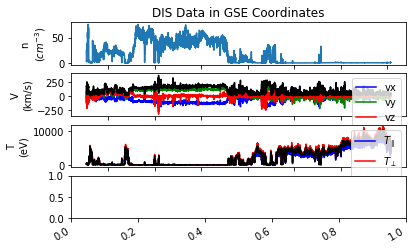

In [27]:
# Visualize the data
fig, ax = plt.subplots(nrows=4, ncols=1, squeeze=False)

fig.autofmt_xdate()

# Density
hn = ax[0,0].plot(dis_t, dis_n)
ax[0,0].set_title('DIS Data in GSE Coordinates')
ax[0,0].set_ylabel('n\n($cm^{-3}$)')

# Velocity
hvx, = ax[1,0].plot(dis_t, dis_v[:,0], 'b', label='vx')
hvy, = ax[1,0].plot(dis_t, dis_v[:,1], 'g', label='vy')
hvz, = ax[1,0].plot(dis_t, dis_v[:,2], 'r', label='vz')
hvz, = ax[1,0].plot(dis_t, dis_vmag, 'k', label='|v|')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel('V\n(km/s)')

# Temperature
htpara, = ax[2,0].plot(dis_t, dis_temp_para, 'b', label='$T_{\parallel}$')
htperp, = ax[2,0].plot(dis_t, dis_temp_perp, 'r', label='$T_{\perp}$')
htperp, = ax[2,0].plot(dis_t, dis_temp, 'k', label='$T$')
ax[2,0].legend(loc='upper right')
ax[2,0].set_ylabel('T\n(eV)')

# Energy Spectrogram
# hespec, = ax[3,0].contour(np.arange(len(dis_t)), dis_e, dis_espec)

plt.show()

<a id='dis_dataframe'></a>
### Data Frame

In [36]:
# Create a dictionary
dis_data = {
    'Time' :  dis_t,
    'N' : dis_n,
    'Vx' : dis_v[:,0],
    'Vy' : dis_v[:,1],
    'Vz' : dis_v[:,2],
    'Vmag' : dis_vmag,
    'Tpara' : dis_temp_para,
    'Tperp' : dis_temp_perp,
    'T' : dis_temp
#    'ESpec': dis_espec,
#    'Energy': dis_e,
}

# Convert dictionary to data from
dis_data = pd.DataFrame(dis_data, columns=dis_data.keys())

<a id='des'></a>
### DES

<a id='des_download_read'></a>
### Download and Read

In [28]:
# Update instrument-specific variables
des_instr = 'fpi'
des_mode = 'fast'

if level == 'sitl':
    des_coords = 'dbcs'
    des_level = 'ql'
    des_optdesc = 'des'
else:
    des_coords = 'gse'
    des_level = level
    des_optdesc = 'des-moms'

# Set attributes
sdc.instr = des_instr
sdc.mode = des_mode
sdc.level = des_level
sdc.optdesc = des_optdesc

# DIS variable names
n_vname = '_'.join((sc, 'des', 'numberdensity', des_mode))
v_vname = '_'.join((sc, 'des', 'bulkv', des_coords, des_mode))
t_para_vname = '_'.join((sc, 'des', 'temppara', des_mode))
t_perp_vname = '_'.join((sc, 'des', 'tempperp', des_mode))
espec_vname = '_'.join((sc, 'des', 'energyspectr', 'omni', des_mode))
pad_low_vname = '_'.join((sc, 'des', 'pitchangdist', 'lowen', des_mode))
pad_mid_vname = '_'.join((sc, 'des', 'pitchangdist', 'miden', des_mode))
pad_high_vname = '_'.join((sc, 'des', 'pitchangdist', 'highen', des_mode))


# Open the file
files = sdc.Download()
files = mms_utils.sort_files(files)[0]

# Read the data
des_t = []
des_n = []
des_v = []
des_temp_para = []
des_temp_perp = []
des_espec = []
des_energy = []
des_pad_low = []
des_pad_mid = []
des_pad_high = []
des_pa = []
print('DES Files:')
for file in files:
    # Open the file
    cdf = pycdf.CDF(file)
    
    # Read timee and shift to center of interval
    #   - There must be a bug in the CDF package because the Epoch_plus_var variables
    #     are read as empty but really contain scalar values
    t = cdf[cdf[n_vname].attrs['DEPEND_0']][:]
#    dt_minus = t.attrs['DELTA_MINUS_VAR']
#    dt_plus = t.attrs['DELTA_PLUS_VAR']
    dt_minus = 0
    dt_plus = 4.5
    t += dt.timedelta(seconds=(dt_plus - dt_minus) / 2.0)
    
    # Read the data
    des_t += list(t)
    des_n += list(cdf[n_vname][:])
    des_v += list(cdf[v_vname][:])
    des_temp_para += list(cdf[t_para_vname][:])
    des_temp_perp += list(cdf[t_perp_vname][:])
    des_espec += list(cdf[espec_vname][:])
    des_energy += list(cdf[cdf[espec_vname].attrs['DEPEND_1']][:])
    des_pad_low += list(cdf[pad_low_vname][:])
    des_pad_mid += list(cdf[pad_mid_vname][:])
    des_pad_high += list(cdf[pad_high_vname][:])
    des_pa += list(cdf[cdf[pad_low_vname].attrs['DEPEND_1']][:])

    # Close the file
    cdf.close()
    print('  ' + file)

# Convert back to numpy arrays
des_t = np.array(des_t)
des_n = np.array(des_n)
des_v = np.array(des_v)
des_temp_para = np.array(des_temp_para)
des_temp_perp = np.array(des_temp_perp)
des_espec = np.array(des_espec)
des_energy = np.array(des_energy)
des_pad_low = np.array(des_pad_low)
des_pad_mid = np.array(des_pad_mid)
des_pad_high = np.array(des_pad_high)
des_pa = np.array(des_pa)

# Compute velocity magnitude
des_vmag = np.sqrt(des_v[:,0]**2.0 + des_v[:,1]**2.0 + des_v[:,2]**2.0)

# Compute scalar temperature
des_temp = 1.0/3.0*(2.0*des_temp_perp + des_temp_para)

# Compute pich angle distribution
des_pad = (des_pad_low + des_pad_mid + des_pad_high) / 3.0

1.75MB [00:10, 183kB/s]                            
3.00MB [00:07, 897kB/s]                            
3.00MB [00:14, 223kB/s]                            
3.00MB [00:10, 307kB/s]                            
2.88MB [00:10, 459kB/s]                            
2.88MB [00:13, 309kB/s]                            
2.75MB [00:09, 318kB/s]                            


DES Files:
  /Users/argall/data/mms1/fpi/fast/ql/des/2016/10/mms1_fpi_fast_ql_des_20161022100000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/des/2016/10/mms1_fpi_fast_ql_des_20161022120000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/des/2016/10/mms1_fpi_fast_ql_des_20161022140000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/des/2016/10/mms1_fpi_fast_ql_des_20161022160000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/des/2016/10/mms1_fpi_fast_ql_des_20161022180000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/des/2016/10/mms1_fpi_fast_ql_des_20161022200000_v3.1.0.cdf
  /Users/argall/data/mms1/fpi/fast/ql/des/2016/10/mms1_fpi_fast_ql_des_20161022220000_v3.1.0.cdf


<a id='des_plot'></a>
### Plot

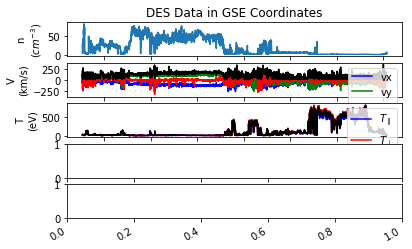

In [29]:
# Visualize the data
fig, ax = plt.subplots(nrows=5, ncols=1, squeeze=False)

fig.autofmt_xdate()

# Density
hn = ax[0,0].plot(des_t, des_n)
ax[0,0].set_title('DES Data in GSE Coordinates')
ax[0,0].set_ylabel('n\n($cm^{-3}$)')

# Velocity
hvx, = ax[1,0].plot(des_t, des_v[:,0], 'b', label='vx')
hvy, = ax[1,0].plot(des_t, des_v[:,1], 'g', label='vy')
hvz, = ax[1,0].plot(des_t, des_v[:,2], 'r', label='vz')
hvz, = ax[1,0].plot(des_t, des_vmag, 'k', label='|v|')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel('V\n(km/s)')

# Temperature
htpara, = ax[2,0].plot(des_t, des_temp_para, 'b', label='$T_{\parallel}$')
htperp, = ax[2,0].plot(des_t, des_temp_perp, 'r', label='$T_{\perp}$')
htperp, = ax[2,0].plot(des_t, des_temp, 'k', label='$T$')
ax[2,0].legend(loc='upper right')
ax[2,0].set_ylabel('T\n(eV)')

# Energy Spectrogram

# Pitch Angle Spectrogram

plt.show()

<a id='des_dataframe'></a>
### Data Frame

In [39]:
# Create a dictionary
des_data = {
    'Time' :  des_t,
    'N' : des_n,
    'Vx' : des_v[:,0],
    'Vy' : des_v[:,1],
    'Vz' : des_v[:,2],
    'Vmag' : des_vmag,
    'Tpara' : des_temp_para,
    'Tperp' : des_temp_perp,
    'T' : des_temp
#    'ESpec': dis_espec,
#    'Energy': dis_e,
#    'PAD': des_pad,
#    'PA': des_pa
}

# Convert dictionary to data from
des_data = pd.DataFrame(des_data, columns=des_data.keys())

<a id='edi'></a>
### EDI

<a id='des_download_read'></a>
### Download and Read

In [12]:
# Update instrument-specific variables
edi_instr = 'edi'
edi_mode = 'srvy'
edi_optdesc = None   # Get whatever is available

if level == 'sitl':
    edi_level = 'ql'
else:
    edi_level = level

# Set attributes
sdc.instr = edi_instr
sdc.mode = edi_mode
sdc.level = edi_level
sdc.optdesc = edi_optdesc

# Figure out which data product is available
files = sdc.FileNames()
parts = mms_utils.parse_filename(files)
edi_optdesc = [p[4] for p in parts]

# EDI variable names
cts1_0_vname = '_'.join((sc, 'edi', 'counts1', '0'))
cts1_180_vname = '_'.join((sc, 'edi', 'counts1', '180'))

# Open the file
files = sdc.Download()
files = mms_utils.sort_files(files)[0]

# Read the data
edi_t = []
edi_cts1_0 = []
edi_cts1_180 = []
print('EDI Files:')
for file in files:
    # Open the file
    cdf = pycdf.CDF(file)
        
    # Read the data
    edi_t += list(cdf[cdf[cts1_0_vname].attrs['DEPEND_0']][:])
    edi_cts1_0 += list(cdf[cts1_0_vname][:])
    edi_cts1_180 += list(cdf[cts1_180_vname][:])

    # Close the file
    cdf.close()
    print('  ' + file)

# Convert back to numpy arrays
edi_t = np.array(edi_t)
edi_cts1_0 = np.array(edi_cts1_0)
edi_cts1_180 = np.array(edi_cts1_180)

EDI Files:
  /Users/argall/data/mms/mms1/edi/srvy/ql/amb/2015/12/mms1_edi_srvy_ql_amb_20151206_v0.1.0.cdf


<a id='des_plot'></a>
### Plot

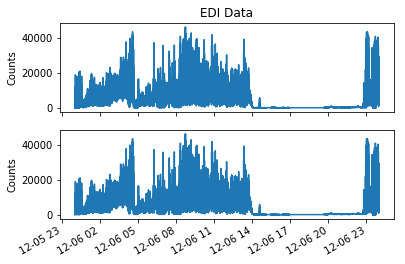

In [13]:
# Visualize the data
fig, ax = plt.subplots(nrows=2, ncols=1, squeeze=False)

fig.autofmt_xdate()

# PA=0
hn = ax[0,0].plot(edi_t, edi_cts1_0)
ax[0,0].set_title('EDI Data')
ax[0,0].set_ylabel('Counts')

# PA=180
hvx, = ax[1,0].plot(edi_t, edi_cts1_0)
ax[1,0].set_ylabel('Counts')

plt.show()

In [26]:
print(edi_data.keys())
print(edi_data['cts1_180'].shape)

dict_keys(['Time', 'cts1_0', 'cts1_180'])
(2440448, 1)


<a id='des_dataframe'></a>
### Data Frame

In [33]:
# Create a dictionary
edi_data = {
    'Time' : edi_t,
    'cts1_0' : edi_cts1_0,
    'cts1_180' : edi_cts1_180
}

# Convert dictionary to data from
print(type(edi_data))
print(edi_data.keys())
print(edi_data['Time'].shape)
edi_data = pd.DataFrame(edi_data, columns=edi_data.keys())

<class 'dict'>
dict_keys(['Time', 'cts1_0', 'cts1_180'])
(1, 2440448)


ValueError: If using all scalar values, you must pass an index

<a id='interpolate_to_des'></a>
## Interpolate All Values to `t_des`
In this step, we need to get all variables into the same time basis. We will interpolate data from FGM and DIS onto the time tags of DES.

In [ ]:
# Convert datetime objects to floats
des_t_stamp = [t.timestamp() for t in des_t]
fgm_t_stamp = [t.timestamp() for t in fgm_t]
dis_t_stamp = [t.timestamp() for t in dis_t]

# Interpolate FGM data
#   - An Nx4 array, ordered as (Bx, By, Bz, |B|)
nTimes = len(des_t_stamp)
nComps = np.size(fgm_b, 1)
fgm_b_interp = np.zeros([nTimes, nComps], dtype=float)
for idx in range(nComps):
    fgm_b_interp[:,idx] = np.interp(des_t_stamp, fgm_t_stamp, fgm_b[:,idx])

# Interpolate DIS data
dis_n_interp = np.interp(des_t_stamp, dis_t_stamp, dis_n)
dis_temp_para_interp = np.interp(des_t_stamp, dis_t_stamp, dis_temp_para)
dis_temp_perp_interp = np.interp(des_t_stamp, dis_t_stamp, dis_temp_perp)

# An Nx3 array, ordered as (Vx, Vy, Vz)
nComps = np.size(dis_v, 1)
dis_v_interp = np.zeros([nTimes, nComps])
for idx in range(nComps):
    dis_v_interp[:,idx] = np.interp(des_t_stamp, dis_t_stamp, dis_v[:,idx])

# Print results
print('Time:                   ', np.shape(des_t), des_t.dtype)
print('DES Density:            ', np.shape(des_n), des_n.dtype)
print('DES Velocity:           ', np.shape(des_v), des_v.dtype)
print('DES Temperature (para): ', np.shape(des_temp_para), des_temp_para.dtype)
print('DES Temperature (perp): ', np.shape(des_temp_perp), des_temp_perp.dtype)
print('FGM Magnetic Field:     ', np.shape(fgm_b_interp), fgm_b_interp.dtype)
print('DIS Density:            ', np.shape(dis_n_interp), dis_n_interp.dtype)
print('DIS Velocity:           ', np.shape(dis_v_interp), dis_v_interp.dtype)
print('DIS Temperature (para): ', np.shape(dis_temp_para_interp), dis_temp_para_interp.dtype)
print('DIS Temperature (perp): ', np.shape(dis_temp_perp_interp), dis_temp_perp_interp.dtype)

In [ ]:
# Visualize the data
fig, ax = plt.subplots(nrows=6, ncols=1, squeeze=False)

fig.autofmt_xdate()

# Magnetic field
hn = ax[0,0].plot(des_t, fgm_b_interp)
ax[0,0].legend(labels=['Bx', 'By', 'Bz', '|B|'])
ax[0,0].set_title(sc + ' Data')
ax[0,0].set_ylabel('B\n(nT)')

# Density
hni, = ax[1,0].plot(des_t, dis_n_interp, label='ni')
hne, = ax[1,0].plot(des_t, des_n, label='ne')
ax[1,0].legend()
ax[1,0].set_ylabel('n\n($cm^{-3}$)')

# DIS Velocity
ax[2,0].plot(des_t, dis_v_interp)
ax[2,0].legend(labels=['Vx', 'Vy', 'Vz'])
ax[2,0].set_ylabel('Vi\n(km/s)')

# DES Velocity
hvx = ax[3,0].plot(des_t, des_v)
ax[3,0].legend(labels=['Vx', 'Vy', 'Vz'])
ax[3,0].set_ylabel('Ve\n(km/s)')

# DIS Temperature
htpara, = ax[4,0].plot(des_t, dis_temp_para_interp, 'b', label='$T_{\parallel}$')
htperp, = ax[4,0].plot(des_t, dis_temp_perp_interp, 'r', label='$T_{\perp}$')
ax[4,0].legend(loc='upper right')
ax[4,0].set_ylabel('Ti\n(eV)')

# DES Temperature
htpara, = ax[5,0].plot(des_t, des_temp_para, 'b', label='$T_{\parallel}$')
htperp, = ax[5,0].plot(des_t, des_temp_perp, 'r', label='$T_{\perp}$')
ax[5,0].legend(loc='upper right')
ax[5,0].set_ylabel('Te\n(eV)')

plt.show()

<a id='wrie_to_csv'></a>
## Write to CSV File
To create a CSV file, we will make use of the `pandas` package. First, we make a data frame and use `pandas` to visualize the data.

In [ ]:
# Open file and write data
data = {
    'Time'   :  des_t,
    'DES N'  : des_n,
    'DES Vx' : des_v[:,0],
    'DES Vy' : des_v[:,1],
    'DES Vz' : des_v[:,2],
    'DES T_para' : des_temp_para,
    'DES T_perp' : des_temp_perp,
    'FGM Bx' : fgm_b_interp[:,0],
    'FGM By' : fgm_b_interp[:,1],
    'FGM Bz' : fgm_b_interp[:,2],
    'FGM Bt' : fgm_b_interp[:,3],
    'DIS N'  : dis_n_interp,
    'DIS Vx' : dis_v_interp[:,0],
    'DIS Vy' : dis_v_interp[:,1],
    'DIS Vz' : dis_v_interp[:,2],
    'DIS T_para' : dis_temp_para_interp,
    'DIS T_perp' : dis_temp_perp_interp,
}

# Create a data frame
data = pd.DataFrame(data, columns=data.keys())

In [ ]:
# Visualize the data
fig, ax = plt.subplots(nrows=6, ncols=1, squeeze=False)

fig.autofmt_xdate()

# Magnetic field
data.plot('Time', 'FGM Bx', ax=ax[0,0], sharex=True)
data.plot('Time', 'FGM By', ax=ax[0,0], sharex=True)
data.plot('Time', 'FGM Bz', ax=ax[0,0], sharex=True)
data.plot('Time', 'FGM Bt', ax=ax[0,0], sharex=True)
ax[0,0].set_ylabel('B\n(nT)')

# Density
data.plot('Time', 'DIS N', ax=ax[1,0], sharex=True)
data.plot('Time', 'DES N', ax=ax[1,0], sharex=True)
ax[1,0].set_ylabel('N\n($cm^{-3}$)')

# DIS Velocity
data.plot('Time', 'DIS Vx', ax=ax[2,0], sharex=True)
data.plot('Time', 'DIS Vy', ax=ax[2,0], sharex=True)
data.plot('Time', 'DIS Vz', ax=ax[2,0], sharex=True)
ax[2,0].set_ylabel('Vi\n(km/s)')

# DES Velocity
data.plot('Time', 'DES Vx', ax=ax[3,0], sharex=True)
data.plot('Time', 'DES Vy', ax=ax[3,0], sharex=True)
data.plot('Time', 'DES Vz', ax=ax[3,0], sharex=True)
ax[3,0].set_ylabel('Ve\n(km/s)')

# DIS Temperature
data.plot('Time', 'DIS T_para', ax=ax[4,0], sharex=True)
data.plot('Time', 'DIS T_perp', ax=ax[4,0], sharex=True)
ax[4,0].set_ylabel('Ti\n(K)')

# DES Temperature
data.plot('Time', 'DES T_para', ax=ax[5,0], sharex=True)
data.plot('Time', 'DES T_perp', ax=ax[5,0], sharex=True)
ax[5,0].set_ylabel('Te\n(K)')

plt.show()

Finally, we output to a CSV file.

In [ ]:
data.to_csv("~/data/output.csv", index=False)

<a id='sitl_selections'></a>
## SITL Selections
The actual selections that the SITL made are saved in separate CSV files accessed through the UNH [MMS data server](http://mmssitl.sr.unh.edu/sitl/).